# Clustering by user-problem matrix

In [1]:
from scipy.sparse import csr_matrix
import numpy as np
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [231]:
import psycopg2
con = psycopg2.connect(database='codeforces', user='Joy')
cur = con.cursor()
q = """
SELECT handle, contestid, problemid
FROM submissions
WHERE
    participanttype!='CONTESTANT'
group by handle, contestid, problemid
"""
cur.execute(q)
keys_practice = cur.fetchall()

[('-----', '106', 'A'),
 ('-----', '110', 'A'),
 ('-----', '110', 'B'),
 ('-----', '112', 'A'),
 ('-----', '112', 'B'),
 ('-----', '114', 'A'),
 ('-----', '116', 'C'),
 ('-----', '117', 'C'),
 ('-----', '118', 'A'),
 ('-----', '120', 'B'),
 ('-----', '124', 'A'),
 ('-----', '131', 'C'),
 ('-----', '230', 'D'),
 ('-----', '50', 'B'),
 ('-----', '58', 'A'),
 ('----ensist----', '1', 'A'),
 ('----ensist----', '158', 'A'),
 ('----ensist----', '208', 'A'),
 ('----ensist----', '216', 'A'),
 ('----ensist----', '217', 'A'),
 ('----ensist----', '217', 'B'),
 ('----ensist----', '218', 'A'),
 ('----ensist----', '218', 'B'),
 ('----ensist----', '218', 'C'),
 ('----ensist----', '218', 'D'),
 ('----ensist----', '219', 'A'),
 ('----ensist----', '219', 'B'),
 ('----ensist----', '219', 'C'),
 ('----ensist----', '220', 'A'),
 ('----ensist----', '221', 'C'),
 ('----ensist----', '263', 'A'),
 ('----ensist----', '263', 'B'),
 ('----ensist----', '266', 'A'),
 ('----ensist----', '266', 'B'),
 ('----ensist----

In [234]:
handles = [x[0] for x in keys_practice]
problems = [x[1] + "_" + x[2] for x in keys_practice]

## Hash handles and problems to rows and columns

In [235]:
hh = {}
hp = {}

row = 0
for h in handles:
    if h not in hh:
        hh[h] = row
        row += 1
col = 0
for p in problems:
    if p not in hp:
        hp[p] = col
        col += 1

In [237]:
row_idx = [hh[h] for h in handles]
col_idx = [hp[p] for p in problems]

In [238]:
# sanity check
print len(row_idx)
print len(col_idx)

5359352
5359352


## Create sparse matrix in CSR format

In [239]:
# csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
ones = np.ones(len(row_idx))
csr = csr_matrix((ones, (row_idx, col_idx)))

In [240]:
csr.shape

(56058, 9891)

In [241]:
svd = TruncatedSVD(n_components=5, n_iter=10, random_state=42)

In [242]:
svd.fit(csr) 

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=10,
       random_state=42, tol=0.0)

In [243]:
print svd.explained_variance_ratio_ 
print svd.explained_variance_ratio_.sum()

[ 0.11447971  0.04064208  0.02810294  0.01528025  0.01452157]
0.213026549593


In [244]:
csr_svd = svd.transform(csr)

In [245]:
csr_svd.shape

(56058, 5)

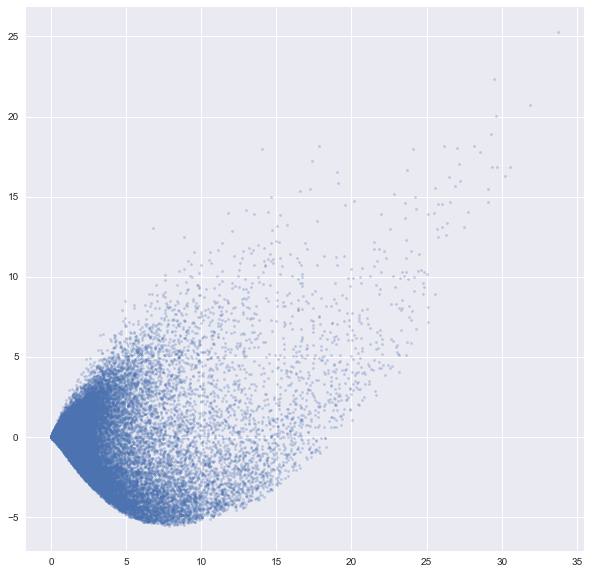

In [246]:
plt.scatter(csr_svd[:, 0], csr_svd[:, 1], s=5, alpha=.3)

###  tSNE
TSNE dies with large data, sub sample

In [247]:
idx = np.random.choice(len(csr_svd), size=10000)
csr_svd_small = csr_svd[idx]

In [248]:
tsne = TSNE()

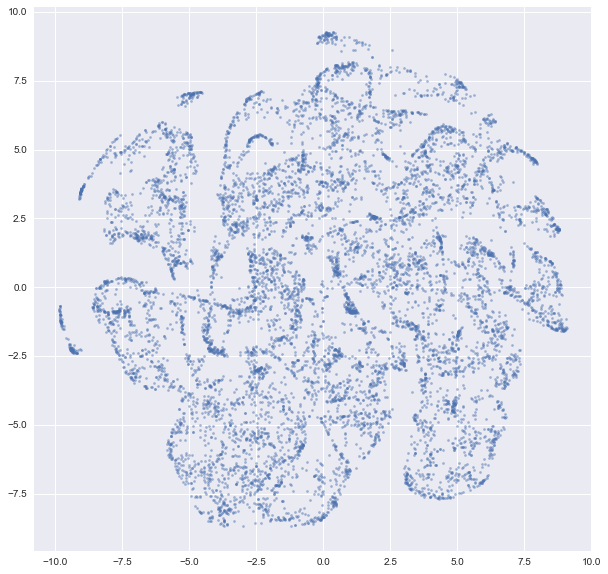

In [249]:
transformed = tsne.fit_transform(csr_svd_small)

plt.scatter(transformed[:, 0], transformed[:,1], s=5, alpha=.5)

# Train/val/test

In [250]:
# reconstruct y column
columns = ['' for i in range(max(hp.values())+1)]
for p in hp:
    columns[ hp[p] ] = p

# reconstruct row labels
rows = ['' for i in range(max(hh.values())+1)]
for h in hh:
    rows[ hh[h] ] = h

In [251]:
# create the ratings vector
ratings = np.zeros(max(hh.values())+1)
for k, v in df_rating.groupby('handle'):
    h = v.handle.values[0]
    if h in hh:
        ratings[ hh[h] ] = v.iloc[-1]['newrating']

In [252]:
with open('set_train.txt') as f:
    settrain = set([t.strip() for t in f.readlines()])
with open('set_test.txt') as f:
    settest = set([t.strip() for t in f.readlines()])
with open('set_val.txt') as f:
    setval = set([t.strip() for t in f.readlines()])

In [298]:
ixtrain = [i for i in range(len(rows)) if rows[i] in settrain]
ixtest = [i for i in range(len(rows)) if rows[i] in settest]
ixval = [i for i in range(len(rows)) if rows[i] in setval]

In [254]:
ytrain = ratings[ixtrain]
print len(ixtrain), ytrain.shape
ytest = ratings[ixtest]
print len(ixtest), ytest.shape
yval = ratings[ixval]
print len(ixval), yval.shape

24914 (24914,)
10545 (10545,)
8116 (8116,)


# Random forest regressor

In [255]:
import pandas as pd
df_rating = pd.read_csv('user_ratings_smoothed.csv')

In [256]:
from sklearn.ensemble import RandomForestRegressor

In [287]:
rf = RandomForestRegressor(n_estimators=20, random_state=12358, verbose=1, min_samples_split=3, n_jobs=-1)

In [288]:
model = rf.fit(csr[ixtrain], ytrain)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.6min finished


In [299]:
print rf.score(csr[ixtrain], ytrain)
print rf.score(csr[ixval], yval)
print rf.score(csr[ixtest], ytest)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


0.918715858632
0.755299522865
0.632045909467


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


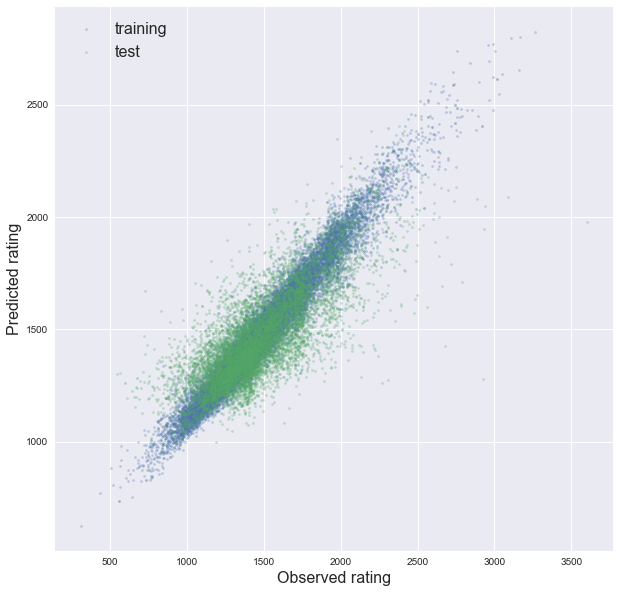

In [300]:
plt.rcParams['figure.figsize'] = (10, 10)
ypred = rf.predict(csr[ixtrain])
plt.scatter(ytrain, ypred, alpha=.3, s=5)
ypred = rf.predict(csr[ixtest])
plt.scatter(ytest, ypred, alpha=.3, s=5)
plt.xlabel('Observed rating', fontsize=16)
plt.ylabel('Predicted rating', fontsize=16)
plt.legend(['training', 'test'], fontsize=16)

In [301]:
imp = pd.Series(rf.feature_importances_)
imp.index = columns

impsorted = imp.sort_values(ascending=False)

In [302]:
problem_rating = pd.read_csv("problem_ratings.csv")
problem_rating['contestid'] = problem_rating.contestid.apply(str)
problem_rating['contestid'] = problem_rating.contestid.apply(lambda x: x + "_")
problem_rating.index = problem_rating.contestid.str.cat(problem_rating.problemid)

In [303]:
imprates = problem_rating.loc[imp.index, 'problemrating']

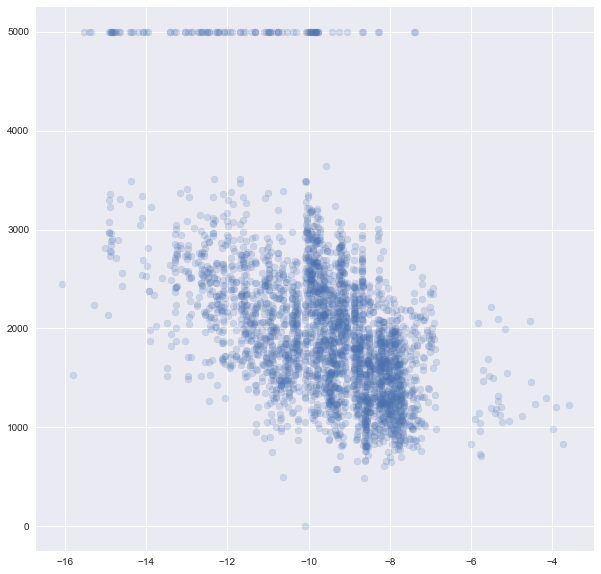

In [304]:
thresh = 0.0000001
plt.scatter(np.log(impsorted[impsorted > thresh]), imprates[impsorted > thresh], alpha=.2)

In [311]:
rf.verbose = 0

In [344]:
import copy
import seaborn as sns

nvars = len(columns)
idx_handle = np.argwhere(np.array(rows) == 'chenmark')[0][0]
oldrating = rf.predict(csr[idx_handle])[0]
print oldrating

2220.49833333


In [336]:
idx = []
newrating = []
usr_row = csr[idx_handle].toarray().reshape(1, -1)
for varidx in range(nvars):
    if usr_row[0][varidx] == 1:
        continue
    testin = usr_row.copy()
    testin[0][varidx] = 1
    predicted_newrating = rf.predict(testin)[0]
    if predicted_newrating != oldrating:
        newrating.append(predicted_newrating)
        idx.append(varidx)

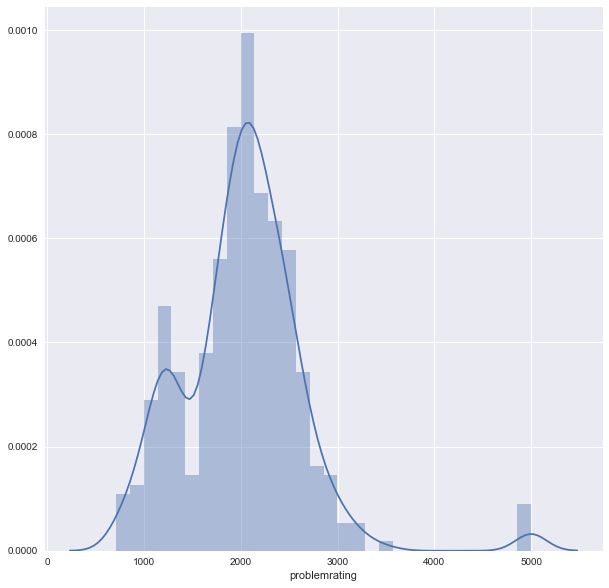

In [337]:
sug_rating = problem_rating.loc[np.array(columns)[idx], 'problemrating'].dropna()
sns.distplot(sug_rating, bins=30)

In [338]:
df_local = pd.DataFrame.from_dict(
    dict(
        problem_rating = problem_rating.loc[np.array(columns)[idx], 'problemrating'],
        newrating = newrating
    )
)

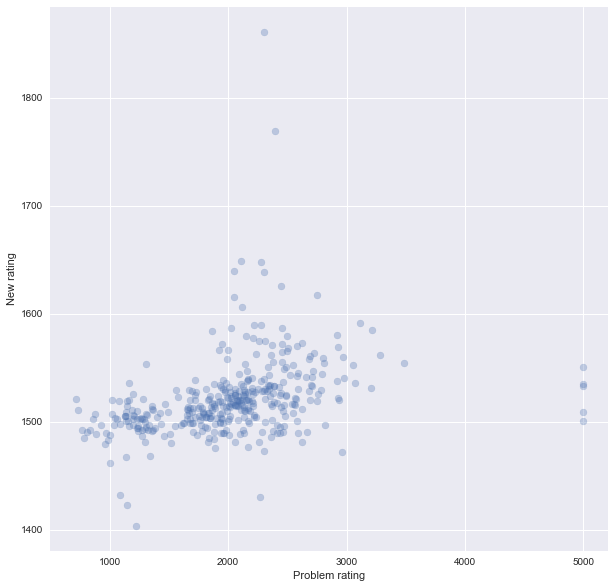

In [342]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.scatter(df_local.problem_rating, df_local.newrating, alpha=.3)
plt.xlabel('Problem rating')
plt.ylabel('New rating')

In [343]:
problem_rating.loc[np.array(columns)[idx]].shape

(449, 3)